In [343]:
from jingle import play_jingle
play_jingle()

# SENSORS' SIGNALS ANALYSIS IN ORDER TO COMPUTE GROUND PROPERTIES

---

### In this notebook, we:

    - Collect sensors' signals (temperature at different depths)
    - Analyze their frequencies (Fourier transform) and phase 
    - Look how they evoluate with the depth
    - Then compute the properties of the ground

---


###  Imports

In [344]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats


# Définir ZERO_CELSIUS (conversion Celsius vers Kelvin)
ZERO_CELSIUS = 273.15


### Chemins

In [345]:
# define the folder path
folder = r'D:\Documents\MINES\2A\MOLONARI\MOLONARI1D\dataAnalysis/'

# read in our data
path_files = folder + 'raw_data/'
path_config= folder + 'configuration/pressure_sensors/'
contenuDossier = os.listdir(path_files)
print(contenuDossier)

# Point
point='point35_07_12_16/'
# le chemin vers le dossier
chemin = path_files + point
# Spécifiez le chemin de votre fichier PNG
chemin_image = chemin + point.split('_')[0] + '_schema.png'

['.DS_Store', 'point13_29_07_15', 'point14_29_07_15', 'point15_29_07_15', 'point34_27_06_16', 'point35_07_12_16', 'point36_12_07_16', 'point46_17_06_19', 'point47_27_08_19', 'point48_14_04_18', 'point52_13_10_23', 'point53_13_10_23', 'schema_dispositif_AvAv_23_07_15.png']


### Fonctions utiles

In [346]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

### Structure de données

In [347]:

# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
dico = {}
# le chemin vers le dossier
dico['chemin'] = path_files + point

with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
    lignes = fichier.readlines()
    # le nom du capteur
    dico['capteur'] = lignes[1][:4]
    # la profondeur du capteur
    dico['profondeur'] = lignes[3]
    # les profondeurs auxquelles on fait les mesures
    dico['profondeurMesures'] = []
    profMes = lignes[5].split(';')
    for num in profMes :
        dico['profondeurMesures'].append(int(num))


    # on va ensuite mettre les dataframes dans le dictionnaire
contenuDossierPoint = os.listdir(dico['chemin'])
for x in contenuDossierPoint:
    # la pression
    if x=="point35_pression_cleaned.csv":
        dico['pression'] = read_csv(dico['chemin'] + '/' + x)
    # la température
    if x=="point35_temperature_cleaned.csv":
        dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
with open(path_config + dico['capteur'].upper() + '.csv') as fichier:
    lignes = fichier.readlines()
    for l in lignes:
        if l.startswith('Intercept'):
            dico['intercept'] = float(l[10:-2])
        if l.startswith('dU/dH'):
            dico['dU/dH'] = float(l[6:-2])
        if l.startswith('dU/dT'):
            dico['dU/dT'] = float(l[6:-2]) 



### Mise en forme des dataframes

In [348]:
# ------------------- Suppression des NAN ------------------------------------------------------------------------------------------


dico['temperature'] = dico['temperature'].dropna(axis = 0, how = 'any')
dico['pression'] = dico['pression'].dropna(axis = 0, how='any')



# ------------------- Modification du format de dates ------------------------------------------------------------------------------


for i in range(len(dico['temperature'].dates)):
    date=dico['temperature'].dates[i]
    jour=str(date.split(' ')[0]).split('-')
    dico['temperature'].dates[i]=str(jour[0]) + "/" + str(jour[1]) + "/" + str(jour[2]) + " " + str(date.split(' ')[1])

for i in range(len(dico['pression'].dates)):
    date=dico['pression'].dates[i]
    jour=str(date.split(' ')[0]).split('-')
    dico['pression'].dates[i]=str(jour[0]) + "/" + str(jour[1]) + "/" + str(jour[2]) + " " + str(date.split(' ')[1])


# Fonction utile : conversion automatique de dates

def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = dico['pression'][dico['pression'].columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")



# Et on convertit directement les dates :

convertDates(dico['temperature'])
convertDates(dico['pression'])
dico['temperature']['dates'].dtype
dico['pression']['dates'].dtype






# ------------------- Renommage des colonnes ----------------------------------------------------------------------------


dico['temperature'].rename(columns={'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164)': 'temperature_depth_1_C'   ,    'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).1': 'temperature_depth_2_C','Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).2': 'temperature_depth_3_C','Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).3': 'temperature_depth_4_C', 'Date Heure, GMT+01:00': 'dates' }, inplace=True)
dico['pression'].rename(columns={'Date Heure, GMT+01:00': 'dates'   ,    'Tension, V (LGR S/N: 10445475, SEN S/N: 10445475, LBL: température)': 'tension_V'   ,   'Temp., °C (LGR S/N: 10445475, SEN S/N: 10445475, LBL: Température)' : 'temperature_stream_C'}, inplace=True)

print("Colonnes température:", dico['temperature'].columns.tolist())
print("Colonnes pression:", dico['pression'].columns.tolist())






# ------------------- Rajout d'une colonne temps écoulé depuis le début et vérification que les dates sont dans le bon ordre (je ne sais pas si c'est utile)-----------------------------------------------------------------------------------------------


# Triez le DataFrame par la colonne de référence temporelle
# 'inplace=True' modifie le DataFrame directement
dico['temperature'].sort_values(by='dates', inplace=True)

# Important : Si vous avez un index, il est préférable de le réinitialiser après le tri
dico['temperature'].reset_index(drop=True, inplace=True)

# Attention : les doublons nous embetent, on les vire
duplicates = dico['temperature']['dates'].duplicated().sum()

if duplicates > 0:
    print(f"Attention : {duplicates} doublon(s) de date trouvé(s).")
    # Pour la plupart des analyses, supprimer les doublons est la meilleure option
    dico['temperature'].drop_duplicates(subset=['dates'], keep='first', inplace=True)
    dico['temperature'].reset_index(drop=True, inplace=True)
    print("Doublons supprimés. Réessayez le calcul.")

# C'est ici qu'on recalcule la colonne du temps écoulé 
t0 = dico['temperature']['dates'].iloc[0]
dico['temperature']['time_days'] = ((dico['temperature']['dates'] - t0).dt.total_seconds() / (24 * 3600)).round(8)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9312\3944018541.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dico['temperature'].dates[i]=str(jour[0]) + "/" + str(jour[1]) + "/" + str(jour[2]) + " " + str(date.split(' ')[1])
C:\Users\mat

Colonnes température: ['dates', 'Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40']
Colonnes pression: ['dates', 'temperature_stream', 'dH']


C:\Users\mathi\AppData\Local\Temp\ipykernel_9312\3944018541.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dico['pression'].dates[i]=str(jour[0]) + "/" + str(jour[1]) + "/" + str(jour[2]) + " " + str(date.split(' ')[1])
C:\Users\mathi\AppData\Local\Temp\ipykernel_9312\3944018541.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Us

### Tracé des températures

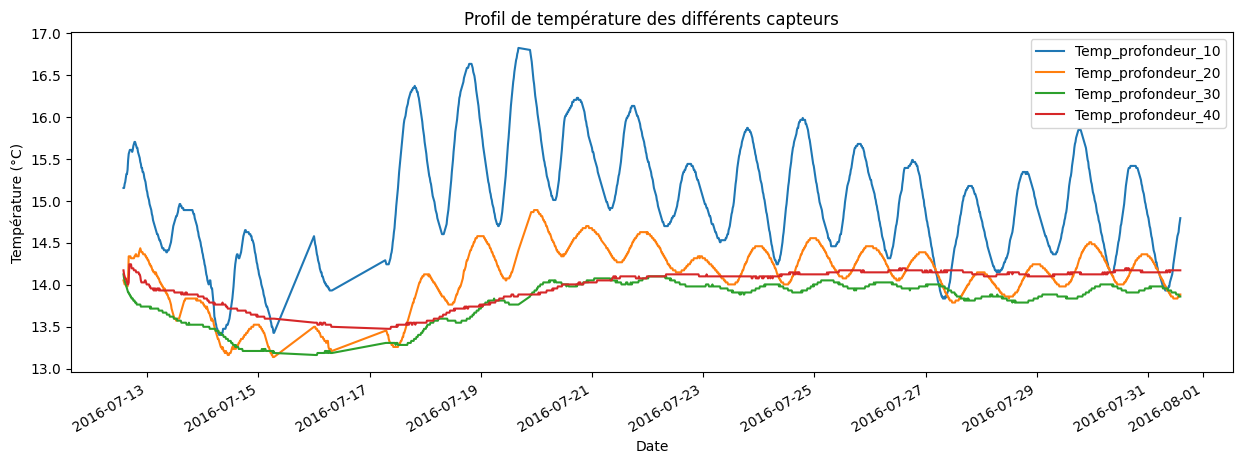

In [349]:
fig, ax = plt.subplots(figsize=(15, 5))

dico['temperature'].plot(x='dates', y=['Temp_profondeur_10', 'Temp_profondeur_20','Temp_profondeur_30', 'Temp_profondeur_40'], ax=ax)

plt.title('Profil de température des différents capteurs')
plt.xlabel('Date')
plt.ylabel('Température (°C)')

plt.show()


### Transormée de Fourier

In [350]:
signals = [
    dico['temperature'].Temp_profondeur_10,  
    dico['temperature'].Temp_profondeur_20,  
    dico['temperature'].Temp_profondeur_30,
    dico['temperature'].Temp_profondeur_40  
]

depth_sensors=dico['profondeurMesures']
dt = 15*NSECINMIN # pas de temps en (s)
input_periods_days=[1]

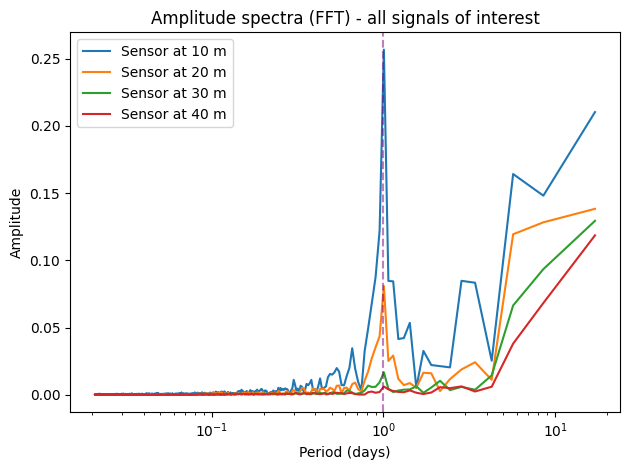

In [351]:
# FFT of the signals of interest on a single plot
sig_arr = np.asarray(signals)           # shape (n_signals, n_time)
n_signals, n_time = sig_arr.shape

freqs = np.fft.rfftfreq(n_time, d=dt)  # cycles per second
mask = freqs > 0
period_days = 1.0 / freqs[mask] / NSECINDAY

plt.figure(figsize=(6.4, 4.8))
cmap = plt.get_cmap("tab10")
for i in range(n_signals):
    y = sig_arr[i].astype(float)
    y -= np.mean(y)
    yf = np.fft.rfft(y)
    amp = np.abs(yf) / n_time
    plt.plot(period_days, amp[mask], color=cmap(i % 10), label=f"Sensor at {depth_sensors[i]} m")


# mark input forcing periods (if available)
try:
    for pday in input_periods_days:
        plt.axvline(pday, color='purple', linestyle='--', alpha=0.5)
except Exception:
    pass



plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Amplitude')
plt.title('Amplitude spectra (FFT) - all signals of interest')
plt.legend()
plt.tight_layout()
plt.show()

### Extraction de l'amplitude des pics

In [352]:
# Create the list of amplitudes for each input period.

amplitudes_at_peaks = []

for i in range(n_signals):
    
    y = sig_arr[i].astype(float)
    y -= np.mean(y)
    yf = np.fft.rfft(y)
    amp = np.abs(yf) / n_time

    phase = np.angle(yf)
    
    # Now find the amplitudes corresponding to the input periods.
    amps_for_signal = []
    for p in input_periods_days:      
        # Find the index of the closest frequency to the input period.
        target_freq = 1.0 / (p * NSECINDAY)
        idx = (np.abs(freqs - target_freq)).argmin()
        amps_for_signal.append(amp[idx])

    amplitudes_at_peaks.append(amps_for_signal)

amplitudes_at_peaks = np.array(amplitudes_at_peaks)  # shape (n_signals, n_input_periods)

Amplitudes for Sensor at 10 m: [0.25674256]
Amplitudes for Sensor at 20 m: [0.08090495]
Amplitudes for Sensor at 30 m: [0.01677865]
Amplitudes for Sensor at 40 m: [0.00619806]


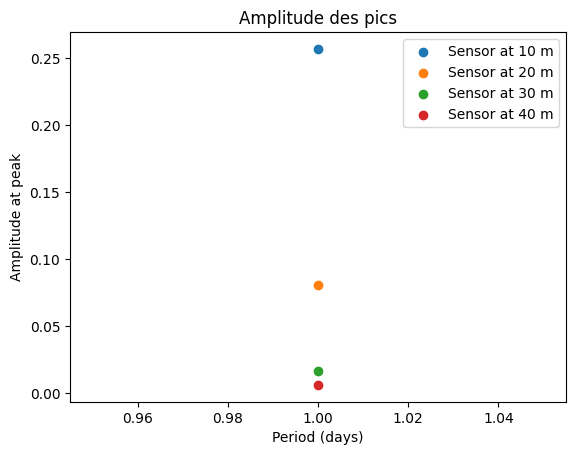

In [363]:
for i in range(n_signals):
    label = f"Sensor at {depth_sensors[i]} m"
    print(f"Amplitudes for {label}: {amplitudes_at_peaks[i]}")

for i in range(n_signals):
    plt.scatter(input_periods_days, amplitudes_at_peaks[i], marker='o', label=(f"Sensor at {depth_sensors[i]} m"))

plt.legend()
plt.xlabel("Period (days)")
plt.ylabel("Amplitude at peak")
plt.title("Amplitude des pics")
plt.show()

### Regression pour trouver $a$ (1/profondeur de pénétration de la décroissance exponentielle)

On trouve a = 0.12744679391607316


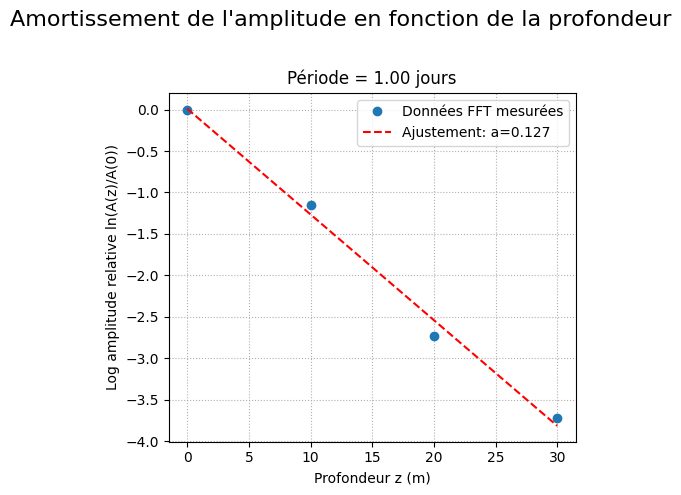

In [364]:
z_values = np.array([0] + depth_sensors[:-1]) 
n_periods = len(input_periods_days)

fig, axs = plt.subplots(1, n_periods, figsize=(5 * n_periods, 5), sharey=False)

# S'il n'y a qu'un seul subplot, axs n'est pas un tableau. On le met dans une liste pour que la boucle fonctionne.
if n_periods == 1:
    axs = [axs]

a_values = []

# Boucle sur chaque période de forçage pour créer un subplot
for i, period in enumerate(input_periods_days):
    ax = axs[i] # Sélectionne l'axe du subplot courant

    # Extraire les amplitudes pour cette période
    amplitudes_for_period = amplitudes_at_peaks[:, i]
    
    # Amplitude de la rivière (référence à z=0)
    amplitude_river = amplitudes_for_period[0]
    
    # Calculer l'amplitude relative A(z)/A(0)
    if amplitude_river > 0:
        amplitude_ratio = amplitudes_for_period / amplitude_river
    else:
        # Éviter la division par zéro si l'amplitude de la rivière est nulle
        amplitude_ratio = np.full_like(amplitudes_for_period, np.nan)
    
    log_amplitude_ratio = np.log(amplitude_ratio)


    # Tracer les données "mesurées" (points)
    ax.plot(z_values, log_amplitude_ratio, 'o', label='Données FFT mesurées')

    # Fit ln(A(z)/A(0)) = -az
    if np.all(np.isfinite(log_amplitude_ratio)):
        # Ajustement linéaire pour trouver a
        coeffs = np.polyfit(z_values, log_amplitude_ratio, 1)
        a_fit = -coeffs[0]
        ax.plot(z_values, np.polyval(coeffs, z_values), 'r--', label=f'Ajustement: a={a_fit:.3f}')
        a_values.append(a_fit)

    print(f"On trouve a = {a_fit}")

    # Mise en forme du subplot
    ax.set_title(f'Période = {period:.2f} jours')
    ax.set_xlabel('Profondeur z (m)')
    ax.legend()
    ax.grid(True, which='both', linestyle=':')

# Mise en forme globale de la figure
axs[0].set_ylabel('Log amplitude relative ln(A(z)/A(0))') # Label Y uniquement pour le premier graphique
fig.suptitle("Amortissement de l'amplitude en fonction de la profondeur", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuste pour laisser de la place au titre principal
plt.show()


### Analyse de la phase

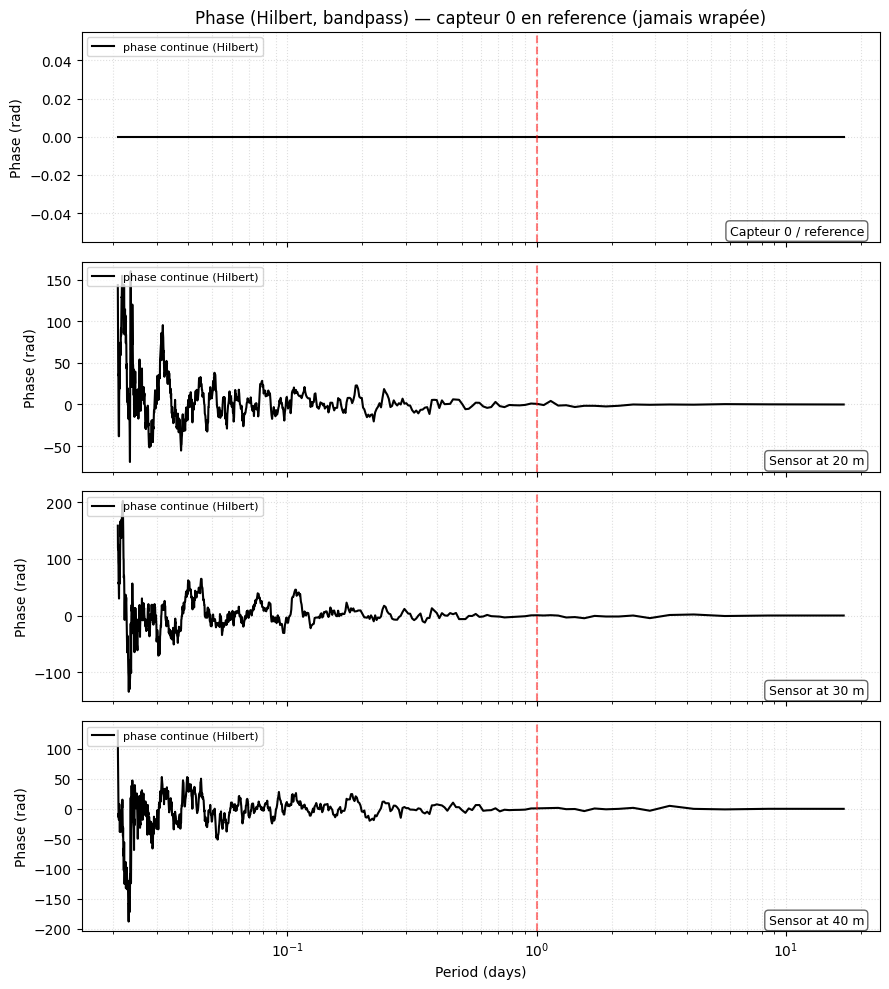

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# ------------------ helpers ------------------

def to_seconds(dates):
    return (dates - dates[0]).astype('timedelta64[s]').astype(np.float64)

def regularize(t, y):
    """Rééchantillonne sur une grille régulière (dt = médiane)."""
    t = np.asarray(t, float); y = np.asarray(y, float)
    m = np.isfinite(t) & np.isfinite(y)
    t = t[m]; y = y[m]
    dt = np.median(np.diff(t))
    if dt <= 0:
        raise ValueError("timestamps non croissants")
    tg = np.arange(t[0], t[-1] + 0.5*dt, dt)
    yg = np.interp(tg, t, y)
    return tg, yg, 1.0/dt

def butter_band(f0, fs, bw_frac=0.2, order=4):
    """Passe-bande centré f0, largeur relative bw_frac (par ex. 0.2 = ±10%)."""
    ny = fs/2
    fl = max(1e-8, f0*(1 - bw_frac/2))
    fh = min(ny*0.99, f0*(1 + bw_frac/2))
    if fl >= fh:
        raise ValueError(f"Bande invalide: fl={fl:.3e} >= fh={fh:.3e}")
    b, a = butter(order, [fl/ny, fh/ny], btype='band')
    return b, a

def analytic_signal(t, y, f0, bw_frac=0.2, order=4):
    """Filtrage bandpass puis signal analytique (complexe)."""
    tg, yg, fs = regularize(t, y)
    b, a = butter_band(f0, fs, bw_frac=bw_frac, order=order)
    yf = filtfilt(b, a, yg)                  # zéro-phase
    z = hilbert(yf)                           # signal analytique
    return tg, z, fs

def continuous_phase_from_complex(z):
    """
    Phase absolue continue SANS wrapping:
    phi[0]=0; phi[k+1]=phi[k] + arg( z[k+1]/z[k] ).
    """
    z = np.asarray(z, complex)
    # petites sécurités si amplitude quasi nulle :
    eps = 1e-12
    z_safe = np.where(np.abs(z) < eps, eps*np.exp(1j*np.angle(z+eps)), z)
    ratio = z_safe[1:] / z_safe[:-1]
    dphi = np.angle(ratio)        # incrément de phase local (petit, donc pas d'ambiguïté 2π)
    phi = np.zeros(len(z_safe))
    phi[1:] = np.cumsum(dphi)
    return phi

# ------------------ pipeline Hilbert par période ------------------

def phases_vs_period_hilbert(dates_mes, signals, period_days,
                             bw_frac=0.2, order=4):
    """
    Calcule la phase continue (jamais wrapée) RELATIVE à la rivière
    pour chaque signal et chaque période de 'period_days'.
    - dates_mes: array datetime64
    - signals: [river, z1, z2, z3, ...] (mêmes longueurs)
    - period_days: array-like des périodes à évaluer (jours)
    Retourne: phases_h (n_signals x n_periods), period_days_out
      où phases_h[i, j] = moyenne temporelle de la phase relative (signal i vs rivière) pour la période j.
      Pour i==0 (rivière), on met 0 par convention.
    """
    t = to_seconds(dates_mes)
    sensors = [np.asarray(s, float) for s in signals]
    n_signals = len(signals)
    periods = np.asarray(period_days, float)

    phases_h = np.zeros((n_signals, len(periods)), dtype=float)

    for j, Pd in enumerate(periods):
        P = Pd * 86400.0
        f0 = 1.0 / P

        # ref : capteur 0
        t_r, z_r, fs = analytic_signal(t, sensors[0], f0, bw_frac=bw_frac, order=order)
        phi_r = continuous_phase_from_complex(z_r)

        # pour chaque capteur : phase continue relative = phi_s - phi_r (interpolée sur t_r)
        for i, s in enumerate(sensors):  # inclut le capteur 0 pour index 0
            if i == 0:
                phases_h[i, j] = 0.0  # référence
                continue
            t_s, z_s, fs_s = analytic_signal(t, s, f0, bw_frac=bw_frac, order=order)
            phi_s = continuous_phase_from_complex(z_s)
            # aligne sur t_r
            phi_s_i = np.interp(t_r, t_s, phi_s)
            dphi = phi_s_i - phi_r        # phase relative continue (jamais wrapée)
            # moyenne temporelle simple (tu peux aussi prendre la médiane)
            phases_h[i, j] = np.mean(dphi)

    return phases_h, periods

# ------------------ exemple de tracé (remplace ton bloc) ------------------

# Entrées attendues déjà définies dans ton contexte :
# - dates_mes : array datetime64
# - signals   : [river, z1, z2, z3]
# - depth_sensors : profondeurs (pour étiquettes)
# - period_days   : les périodes à balayer (jours) -> si tu as déjà period_days, on l'utilise;
#   sinon crée-le, par ex. period_days = np.logspace(np.log10(0.3), np.log10(30), 100)


# calcule les phases "Hilbert, non wrapées" vs période :
phases_h, period_days_out = phases_vs_period_hilbert(
    dico['temperature']['dates'].values, signals, period_days,
    bw_frac=0.2,   # ±10% autour de f0
    order=4
)

n_signals, n_freqs = phases_h.shape

fig, axes = plt.subplots(n_signals, 1, figsize=(9, 2.5 * n_signals), sharex=True)
if n_signals == 1:
    axes = [axes]


for i in range(n_signals):
    ax = axes[i]
    ph = phases_h[i]  # déjà continue, sans wrap, sans rescaling
    ax.plot(period_days_out, ph, '-k', label='phase continue (Hilbert)')
    ax.set_xscale('log')
    ax.set_ylabel('Phase (rad)')
    if i == 0:
        ax.set_title('Phase (Hilbert, bandpass) — capteur 0 en reference (jamais wrapée)')
        label = "Capteur 0 / reference"
    else:
        depth_label = depth_sensors[i] if i < len(depth_sensors) else f"idx {i}"
        label = f"Sensor at {depth_label} m"
    ax.text(0.98, 0.02, label, transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', alpha=0.6))

    for pday in input_periods_days:
        ax.axvline(pday, color='r', linestyle='--', alpha=0.5)

    #ax.set_xlim(0.2, 10)

    ax.grid(True, which='both', ls=':', alpha=0.4)
    ax.legend(loc='upper left', fontsize=8)

axes[-1].set_xlabel('Period (days)')
plt.tight_layout()
plt.show()

### Extraction des valeurs des phases

In [356]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, hilbert

def _to_seconds(dates):
    return (dates - dates[0]).astype('timedelta64[s]').astype(float)

def _regularize(t, y):
    t = np.asarray(t, float); y = np.asarray(y, float)
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    dt = np.median(np.diff(t))
    tg = np.arange(t[0], t[-1] + 0.5*dt, dt)
    yg = np.interp(tg, t, y)
    return tg, yg, 1.0/dt

def _butter_band(f0, fs, bw_frac=0.15, order=4):
    ny = fs/2
    fl = max(1e-8, f0*(1 - bw_frac/2))
    fh = min(ny*0.99, f0*(1 + bw_frac/2))
    b, a = butter(order, [fl/ny, fh/ny], btype='band')
    return b, a

def _analytic_bandpassed(t, y, f0, bw_frac=0.15, order=4):
    tg, yg, fs = _regularize(t, y)
    b, a = _butter_band(f0, fs, bw_frac=bw_frac, order=order)
    yf = filtfilt(b, a, yg)               # zéro-déphasage
    z = hilbert(yf)                        # signal analytique
    return tg, z

def _circ_mean(ph):
    # moyenne circulaire : angle de la moyenne des exponentielles
    return np.angle(np.mean(np.exp(1j*ph)))

def phases_at_input_periods_circular(dates_mes, signals, depth_sensors, input_periods_days,
                                     bw_frac=0.15, order=4, amp_thresh=None):
    """
    Phase relative (mod 2π) par *période d'intérêt*:
      - filtre passe-bande
      - phase instantanée Δφ(t) = arg(z_s * conj(z_r))
      - moyenne circulaire dans le temps
      - unwrap le vecteur obtenu le long des profondeurs (par période)
    Retourne un DataFrame (lignes = périodes, colonnes = rivière + profondeurs).
    """
    t = _to_seconds(dates_mes)
    sensors = [np.asarray(s, float) for s in signals]
    zdepths = np.asarray(depth_sensors, float)

    rows = []
    for Pd in input_periods_days:
        f0 = 1.0 / (Pd * 86400.0)

        # signal analytique filtré (capteur 0)
        tr, zr = _analytic_bandpassed(t, sensors[0], f0, bw_frac=bw_frac, order=order)

        phases_rel = [0.0]  # 0 pour la référence
        for s in sensors[1:]:
            ts, zs = _analytic_bandpassed(t, s, f0, bw_frac=bw_frac, order=order)

            # aligner temporellement
            # on interpole le complexe (OK sur petites dérives)
            zs_i = np.interp(tr, ts, zs.real) + 1j*np.interp(tr, ts, zs.imag)

            # option: rejeter les instants à faible amplitude (SNR faible)
            if amp_thresh is not None:
                m = (np.abs(zr) > amp_thresh) & (np.abs(zs_i) > amp_thresh)
                if m.sum() < 10:
                    phases_rel.append(np.nan)
                    continue
                dphi_t = np.angle(zs_i[m] * np.conj(zr[m]))
            else:
                dphi_t = np.angle(zs_i * np.conj(zr))

            phi_hat = _circ_mean(dphi_t)     # dans (-π, π]
            phases_rel.append(phi_hat)

        # unwrap cohérent le long des profondeurs (pour cette période)
        ph = np.array(phases_rel, float)               # [z0, z1, z2, ...]
        ph_unw = np.unwrap(ph)                         # continu en profondeur
        # convention physique: retard => négatif; force dans la branche ≤ 0
        # (on autorise un décalage de ±2π pour rendre tout ≤ 0 et monotone)
        for k in range(1, len(ph_unw)):
            while ph_unw[k] > ph_unw[k-1]:
                ph_unw[k] -= 2*np.pi

        rows.append([Pd] + ph_unw.tolist())

    cols = [f"Capteur 0 (ref) à {zdepths[0]:.2f}"] + [f"{z:.2f} m" for z in zdepths[1:]]
    df = pd.DataFrame(rows, columns=["Period (days)"] + cols).set_index("Period (days)")
    return df

In [357]:
df_phase = phases_at_input_periods_circular(
    dates_mes=dico['temperature']['dates'].values,
    signals=signals,                   # [z0, z1, z2, z3]
    depth_sensors=depth_sensors,
    input_periods_days=input_periods_days,   # périodes (jours)
    bw_frac=0.15, order=4,
    amp_thresh=None   # mets p.ex. amp_thresh=np.percentile(np.abs(hilbert(river)), 20) pour être plus strict
)
print(df_phase.round(3))

               Capteur 0 (ref) à 10.00  20.00 m  30.00 m  40.00 m
Period (days)                                                    
1                                  0.0   -1.035   -2.675   -5.186


### Regression des phases pour trouver $b$

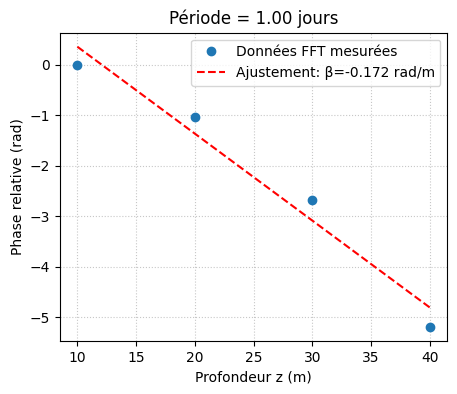

Période 1.00 jours: β = -0.172 rad/m


In [358]:
# Pour chaque période, on essaye de faire passer un fit phi(z) = beta_z

# Pour chaque période,
betas = []
for period, row in df_phase.iterrows():
    depths = np.array(depth_sensors, float) 
    phases = row.values.astype(float)                     # [z0, z1, z2, z3]
    m = np.isfinite(phases)
    if m.sum() < 2:
        betas.append(np.nan)
        continue
    coeffs = np.polyfit(depths[m], phases[m], 1)          # fit linéaire
    beta = coeffs[0]
    betas.append(beta)

    # Plotting for confirmation
    plt.figure(figsize=(5, 4))
    plt.plot(depths, phases, 'o', label='Données FFT mesurées')
    plt.plot(depths, np.polyval(coeffs, depths), 'r--', label=f'Ajustement: β={beta:.3f} rad/m')
    plt.xlabel('Profondeur z (m)')
    plt.ylabel('Phase relative (rad)')
    plt.title(f'Période = {period:.2f} jours')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', alpha=0.7)
    plt.show()
    print(f"Période {period:.2f} jours: β = {beta:.3f} rad/m")

### Récapitulatif

In [359]:
a = np.array(a_values)
b = -np.array(betas)
vt_sur_kappa = (b**2 - a**2)/a

print("\n--- Comparaison des coefficients a et b ---")
print("a:", a)
print("b:", b)
print("Périodes (jours):", input_periods_days)
print("vt/κ:", vt_sur_kappa)


--- Comparaison des coefficients a et b ---
a: [0.12744679]
b: [0.171988]
Périodes (jours): [1]
vt/κ: [0.10464905]


### Inversion par résolution matricielle.

In [367]:
def inversion(a, b, P):

    # b(b^2 + a^2)/(2a) = pi/(kappa_e * P)
    kappa_e = (np.pi * 2 * a) / (P *  b * (b**2 + a**2))

    # (b^2 - a^2)/a = v_t/kappa_e
    v_t = kappa_e * (b**2 - a**2) / a

    return kappa_e, v_t

for a_val, b_val, P in zip(a, b, input_periods_days):
    kappa_e, v_t = inversion(a_val, b_val, P * 86400.0)
    print(f"Période : {P:.2f} jours \nkappa_e = {kappa_e:.3e} m²/s \nv_t = {v_t:.3e} m/s")

Période : 1.00 jours 
kappa_e = 1.176e-03 m²/s 
v_t = 1.231e-04 m/s


## Verification

$$\kappa_e = \dfrac{\lambda_m}{\rho_m c_m} \qquad v_t = -\alpha_e \dfrac{dH}{dz}$$
Avec :
- $\alpha_e = \dfrac{\rho_m c_m}{\rho_w c_w}$


In [361]:
def kappa_e(poro, lambda_w, rho_w_c_w, lambda_s, rho_s_c_s):
    """
    Calcul de la diffusivité thermique effective kappa_e [m²/s]
    poro: porosité (0-1)
    lambda_w: conductivité thermique de l'eau [W/m/K]
    rho_w_c_w: capacité calorifique volumique de l'eau [J/m³/K]
    lambda_s: conductivité thermique des solides [W/m/K]
    rho_s_c_s: capacité calorifique volumique des solides [J/m³/K]
    n: indice de saturation hydraulique (0-1)
    q: vitesse d'écoulement verticale moyenne [m/s] (positive vers le bas)
    """
    return (poro * lambda_w + (1 - poro) * lambda_s) / (poro * rho_w_c_w + (1 - poro) * rho_s_c_s)
    

poro = 0.1
lambda_w = 0.6
rho_w_c_w = 4.18e6
lambda_s = 1.0
rho_s_c_s = 4e6

kappa_e = kappa_e(poro, lambda_w, rho_w_c_w, lambda_s, rho_s_c_s)
print(f"Estimated kappa_e = {kappa_e:.3e} m²/s")

Estimated kappa_e = 2.389e-07 m²/s
